In [66]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats,signal
from scipy.optimize import curve_fit
from scipy.special import factorial

# Preparing Higgs Data
higg = open ("higgs_100000_pt_1000_1200.pkl",'rb')
higgD = pickle.load(higg)

# Preparing QCD Data
qcd = open ("qcd_100000_pt_1000_1200.pkl",'rb')
qcdD = pickle.load(qcd)

higgs_qcd_stuff = {
    "PT" : {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['pt']       
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['pt']
        },
        "title":"Higgs and QCD Angular Momentum",
        "xlabel":"pt(GeV)",
    },
    "ETA": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['eta']       
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['eta']
        },
        "title":"Higgs and QCD Pseudorapidity",
        "xlabel":"n (-Pi to Pi)",
    },
    "PHI": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['phi']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['phi']
        },
        "title":"Higgs and QCD Azimuthal Angle",
        "xlabel":"n (-Pi to Pi)",
    },
    "MASS": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['mass']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['mass']
        },
        "title":"Higgs and QCD Mass",
        "xlabel":"Mass (GeV)",
    },
    "EE2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['ee2']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['ee2']
        },
        "title":"Higgs and QCD 2-Point ECF Ratio"
    },
    "EE3": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['ee3']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['ee3']
        },
        "title":"Higgs and QCD 3-Point ECF Ratio"
    },
    "D2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['d2']     
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['d2']
        },
        "title":"Higgs and QCD 3-to-2 Point ECF Ratio"
    },
    "ANG": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['angularity']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['angularity']
        },
        "title":"Higgs and QCD Angularity",
        "xlabel":"Angularity (tau_a)",
    },
    "T1": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t1']   
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t1']
        },
        "title":"Higgs and QCD Subjettiness - tau1"
    },
    "T2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t2']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t2']
        },
        "title":"Higgs and QCD Subjettiness - tau2"
    },
    "T3": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t3']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t3']
        },
        "title":"Higgs and QCD Subjettiness - tau3"
    },
    "T21": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t21']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t21']
        },
        "title":"Higgs and QCD Subjettiness - tau21"
    },
    "T32": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t32']    
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t32']
        },
        "title":"Higgs and QCD Subjettiness - tau32"
    },
    "KTDR": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['KtDeltaR']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['KtDeltaR']
        },
        "title":"Higgs and QCD KtDeltaR"
    }
}

## Intro
In this part of the lab, I will use the selection of data with a pT range of 1000-1200

## Problem 1

Below is a stacked histogram of QCD background mass and optimized mass, both log-scale and non-log-scale. This visualization will be useful when we optimize our data.

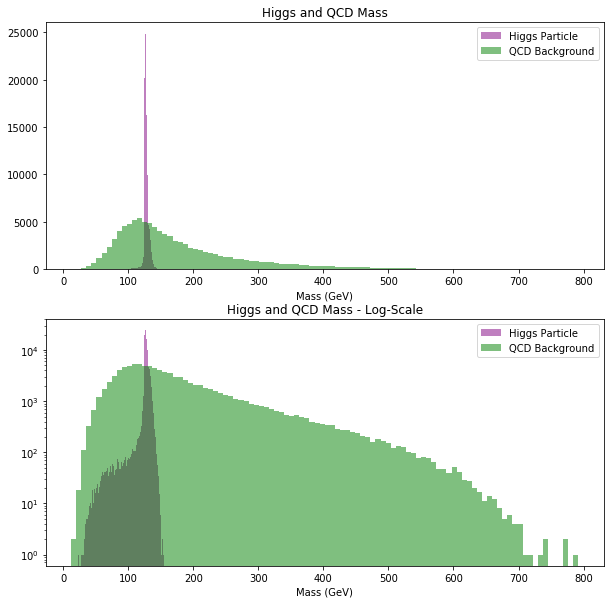

In [108]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

for i in range(0,2):
    ax[i].hist(
        higgs_qcd_stuff['MASS']['higgs_detail']['data'],
        bins=100,
        color='purple',
        alpha=0.5,
        label='Higgs Particle')
    ax[i].hist(
        higgs_qcd_stuff['MASS']['qcd_detail']['data'],
        bins=100,
        color='green',
        alpha=0.5,
        label='QCD Background')
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Mass (GeV)")

# Graph details that differ between log and non-log scale visualizations
ax[0].set_title(higgs_qcd_stuff['MASS']['title'])
ax[1].set_title(f"{higgs_qcd_stuff['MASS']['title']} - Log-Scale")
ax[1].set_yscale('log')

plt.show()

### We Ask the Question:
What would be our expected significance without first optimizing our data (or, assuming our background is already optimized), and how does it compare to the actual significance? 

Note that the true significance is equivalent to: $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$

### Assumptions
We can first make a couple of assumptions based on the above. 
1. A Poisson fit will give us a high mean. This is because the majority of the background data lies far to the right of our true signal data, and so will increase the mean. 
2. A Poisson fit will not be a good fit. We know that a Poisson distribution is Gaussian-like when $\mu$ gets large. In the above visualizations see that this is not true, because the normal-scale visualization is not Gaussian, and the log-scale visualization is not a parabola. 
3. Because of the above, I expect our significance to be larger than it should be.

### Graphing The Best Fit Line
Below we graph the best-fit Poisson distribution whose mean is the same as that of our background data: 

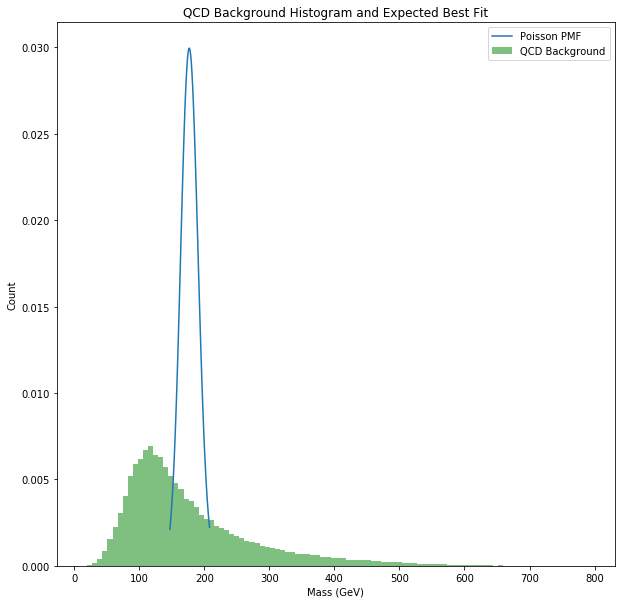

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Make Poisson representation with the mean of our background data
qcdMu = np.mean(higgs_qcd_stuff['MASS']['qcd_detail']['data'])
x = np.arange(stats.poisson.ppf(0.01, mu=qcdMu),stats.poisson.ppf(0.99, mu=qcdMu))

# Prepare the best-fit distribution
ax.plot(
    x, 
    stats.poisson.pmf(x, mu=qcdMu), 
    ms=4, 
    label='Poisson PMF')

# Prepare background data
ax.hist(higgs_qcd_stuff['MASS']['qcd_detail']['data'],
        bins=100,
        color='green',
        alpha=0.5, 
        label='QCD Background', 
        density=True)

# Set graph details
ax.legend(loc='upper right')
ax.set_title("QCD Background Histogram and Expected Best Fit")
ax.set_ylabel("Count")
ax.set_xlabel("Mass (GeV)")

plt.show()

With the above code, we know that the mean of our background, and what should be the mean of our Poisson best-fit distribution is 177.23 (the value of the variable qcdMu).

We will now find and compare our significance to  $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$

In [9]:
cdf = stats.poisson.cdf(125,mu=177)
sig = stats.norm.ppf(cdf)
signif = 50/np.sqrt(2000)
print(f"'Best-Fit' Significance: {sig}")
print(f"Actual Significance: {signif}")

'Best-Fit' Significance: -4.072729796123784
Actual Significance: 1.118033988749895


### Moving Past Roadblocks
The above value for the best-fit significance in comparison to the actual significance shows that there is a lot of background noise that is throwing off our answer, and Poisson is not a good way to fit this data. If my assumptions as stated before were false, then this best-fit significance would have produced a number that was considerably closer than the value given. 

Because we do want to show that the value of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ can be used as a reasonable method to find significance, we will instead use the mode. 
The mode of our data is the peak. If this were truly Poisson distributed, the mode and the mean would be the same, so we wouldn't need to bother with the difference between mode and mean. In this case, as stated, this is not Poisson distributed and so the mode and mean are not the same. However, we do care about the mode more than the mean in this case simply because this is where our 0$\sigma$ value lies. 
Below I use a value of 114, as this is the rounded mode of the background. 

In [42]:
cdfMode = stats.poisson.cdf(125,mu=114)
sigMode = stats.norm.ppf(cdfMode)
signifMode = 50/np.sqrt(2000)
print(f"'Best-Fit' Significance: {sigMode}")
print(f"Actual Significance: {signifMode}")

'Best-Fit' Significance: 1.0750588645079644
Actual Significance: 1.118033988749895


We can now conclude with certainty that the value of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ can be used to find, or give a very good estimate of, significance. 

## Problem 2

### We Ask the Question:
What threshold values would best optimize our background so that we can keep the maximum good data and also the minimum background data?

### Why We Ask this Question:
We have already established that there is an astounding amount of background noise that will always cause inacurate experiement outcomes (again, note the best-fit as calculated with the mean). So, we need to be able to cut the data at such a point that gives us the best possible significance (as compared to our known, actual significance). This means we have the find the perfect balance between throwing away good data, and keeping bad background data, such that it maximizes our chances of detecting the signal we're hunting for. 

### Method Moving Forward
We will use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to test our thresholds. 

First, we will identify a few thresholds which appear significant and should be part of our tests:
* Min/Max values
    * Chosen because these are the start and end of the entire array of data
* 100/150 
    * 100 appears to be where the data begins to be spiking upward
    * 140 appears to be where the data falls off sharply 
* 124/128
    * +-2 from the actual mass of 126GeV
    
### Things to Think About
The spike in the Mass graph correctly identifies the actual mass of the Higgs Boson at 126 GeV. One would initially suspect that the y-axis would show raw count of how many particles were found at this mass. However, we know that the data provided has an NHiggs value of 50; the graph goes to nearly 25000. We must consider the implications of this before moving forward so that we can properly utilize the counts that are extracted from our chosen thresholds. 


### Actually Moving Forward
We will find the values between these thresholds to count the values at and between the thresholds, and use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to find significance

The first tests will help us to identify where we can begin testing with smaller iterations. With $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$, we can loop over more and more granular index values to find the optimal threshold. Our final choice should be VERY close to 1.118

In [106]:
xlow = [min(round(higgs_qcd_stuff['MASS']['higgs_detail']['data'])),100,124]
xhigh = [max(round(higgs_qcd_stuff['MASS']['higgs_detail']['data'])),150,128]


counts_d = {}
for i in range(0,3):
    # Start counts at 1 because indexing goes from 0-99999, 
    # which means if we start the count at 0 we will always be one short
    higgs_count = 1
    qcd_count = 1
    for hval,qval in zip(
        higgs_qcd_stuff['MASS']['higgs_detail']['data'],
        higgs_qcd_stuff['MASS']['qcd_detail']['data']):
        if xlow[i] <= hval <= xhigh[i]:
            higgs_count+=1
        if xlow[i] <= qval <= xhigh[i]:
            qcd_count+=1
            
    higgs_key = f"higgs_count{i}"
    qcd_key = f"qcd_count{i}"
    counts_d.update({higgs_key:higgs_count})
    counts_d.update({qcd_key:qcd_count})

print(counts_d['higgs_count0'],counts_d['qcd_count0'])
print(counts_d['higgs_count1'],counts_d['qcd_count1'])
print(counts_d['higgs_count2'],counts_d['qcd_count2'])


100000 53395
98053 31312
59145 2521


In [ ]:
100000 53395
98053 31312
59145 2521

higgscount2=1
qcdCount2=1
for hval,qval in zip(higgsMass,qcdMass):
    if hval >= xlow[1] and hval <= xhigh[1]:
        higgscount2+=1
    if qval >= xlow[1] and qval <= xhigh[1]:
        qcdCount2+=1
        
higgscount3=1
qcdCount3=1
for hval,qval in zip(higgsMass,qcdMass):
    if hval >= xlow[2] and hval <= xhigh[2]:
        higgscount3+=1
    if qval >= xlow[2] and qval <= xhigh[2]:
        qcdCount3+=1

indlow = []
indhigh = []
for i in xhigh:
    indhigh.append(list(round(higgsMass)).index(i))
    continue     

higgs_copy_1 = higgsMass.copy()
higgs_slice_1 = higgs_copy_1[indlow[0]:indhigh[0]]
print(indlow[0],indhigh[0])

qcd_slice_1

higgs_slice_2
qcd_slice_2

higgs_slice_3
qcd_slice_3

print(higgscount1/np.sqrt(qcdCount1))
print(higgscount2/np.sqrt(qcdCount2))
print(higgscount3/np.sqrt(qcdCount3))

## Problem 3
We want to have visualizations of all of our features.

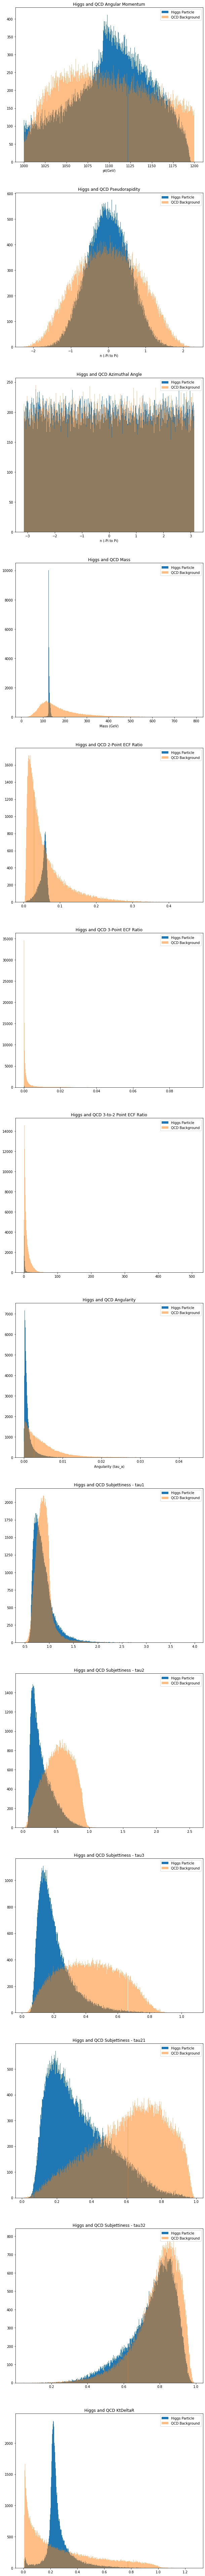

In [105]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))
features_list=['PT','ETA','PHI','MASS','EE2','EE3','D2','ANG','T1','T2','T3','T21','T32','KTDR']

for i in range(len(features_list)):
    # Creating a histogram of Higgs data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""),
        500,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label',""))
    # Creating a histogram of QCD data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""),
        500,
        alpha=.5,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',""))
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',""))
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',""))
    ax[i].legend(loc='upper right')
    
plt.show() 
    
    

We should now decide if there are any other features that we could use in order to optimize our background data. 

As discussed in a previous lab, the following features are ones which we could utilize:

* **Invariant Mass**
    * Chosen due to the clear peak at 125 GeV, which is the known mass of the Higgs boson
* **Angularity** 
    * Chosen because of the clear peak the Higgs data has over the QCD background data. In addition, there are useful data in regards to decays given an upper and lower bound in the Higgs distribution.
* **$\tau$21** 
    * Is a suggested excellent jet discriminator between background and boosted object jets. This suggestion is validated based on the comparison between $\tau$21 and $\tau$32
    
### Optimizing with Mass
With the thresholds we ultimately found to be the best in Problem 2, we will now extract the data that we want from all features.

## Problem 4

## Problem 5